# Mapas y embebidos: Reconstrucción de atractores caóticos

---
En física, y en general en distintas áreas de la ciencia, es común trabajar realizando mediciones de una cierta magnitud escalar a una frecuencia de muestreo fija. *Una cierta magnitud escalar* significa **una sola** magnitud (con suerte, si el equipamiento lo permite, dos): por ejemplo, podemos estar midiendo una diferencia de tensión entre dos puntos de un circuito, la deformación o desplazamiento de un sistema mecánico en una determinada dirección. La pregunta que intenta abordar este trabajo es si, a partir de una sola medición de una magnitud escalar puedo reconstruir, al menos cualitativa o parcialmente, las trayectorias que realiza el sistema estudiado en el espacio de fases. La respuesta es que, a veces (con trabajo y cuidado), si se puede.

Lo que asegura que uno pueda reconstruir el espacio de fases es el teorema atribuido a Taken, sobre el cual no voy a ahondar, pero pueden encontrarse explicaciones en [Wikipedia](https://en.wikipedia.org/wiki/Takens%27_theorem) y [Analysis of observed chaotic data][1]. La idea detrás de la reconstrucción, como se explica en [Mancho][2], es la siguiente: si la ley que rige el comportamiento de la magnitud medida es determinística, existirá algún número $n$ para la cual la serie de datos obtenida nos permitirá predecir datos subsiguientes. Es decir, si medimos una variable llamada $x$ y obtenemos una serie de datos $\{x_i; i=k,...,k+n-1\}$, podemos predecir la medición $k+n$ que hubieramos obtenido al hacer una medición más: $\{x_i; i=k,...,k+n\}$. Luego, podemos asignar un vector $\{X=x_i; i=k,...,k+n-1\}$ a $n$ sucesivas mediciones y representar a la serie escalar en un espacio multidimensional.

La técnica usual para reconstruir el espacio de fases consiste en tomar una serie tridimensional usando coordenadas retardadas. Esto es, si la serie medida es $x(t)$, construir el vector $(x(t), x(t-\tau), x(t-2\tau), x(t-3\tau)...x(t-n\tau))$, con $n$ la dimensionalidad del sistema y $\tau$ algún valor fijo. El teorema de Takens asegura, bajo ciertas condiciones como suavidad de la serie $x(t)$, que la serie obtenida de tomar coordenadas retardas es un difeomorfismo del espacio de fases del sistema original (del espacio de fases original al reconstruido hay un cambio de variables suave e inversible). En el caso general en que uno se olvida del teorema de Takens, puede considerar que el espacio reconstruido es "bueno" si: (1) existe un mapa uno a uno entre la trayectoria original y la reconstruida y (2) se conserva la información diferencial.

En este trabajo, se usa la técnica de realizar embebidos tomando coordenadas retardadas para reconstruir el atractor de Rössler. Las series temporales se obtienen mediante integración numérica de las ecuaciones utilizando el método de Runge-Kutta de orden 4, escrito en C. Veremos que si bien es posible realizar reconstrucciones topológicamente equivalentes a los atractores originales, ese no siempre es el caso. Es decir, los embebidos no son únicos, y distintos embebidos pueden dar lugar a reconstrucciones topológicamente inequivalentes entre si (e inequivalentes respecto del atractor original). Además, se discutirá brevemente el método utilizado para elegir el tiempo de retardo. Salvo la integración de las ecuaciones, todo el análisis numérico de los datos se realiza en Python.

## Tiempos de retardo

La receta utilizada para reconstruir los atractores consiste en tomar la serie temporal de alguna coordenada, por ejemplo $x(t)$, y armar la serie vectorial $(x(t), x(t-\tau), x(t-2\tau))$. Nos conformamos con tres dimensiones porque sabemos que los atractores viven en un espacio tridimensional, pero en el caso de no conocer de antemano a las ecuaciones que rigen el sistema, ni su dimensionalidad, la elección no es tan trivial. El problema consiste entonces en encontrar el tiempo de retardo $\tau$ óptimo: aquel que resulte en un mapa uno a uno, conserve la información diferencial y, ojalá, sea topológicamente equivalente al atractor original. El problema con la elección del tiempo de retardo reside en que el teorema de Takens es totalmente invisible al retardo, no da ninguna prescripción para el salvo prohibir ciertos múltiplos del período de señales periódicas. Por esta razón, es necesario encontrar alguna prescripción basada en algún argumento que parezca lógico.

Para empezar, conviene pensar qué se quiere conseguir. Por ejemplo, dado que los datos obtenidos provienen de realizar integraciones numéricas con un paso fijo (y en general se mide a frecuencias de muestreo fijas), debemos elegir un tiempo de retardo que sea algún múltiplo del paso de integración. Por otro lado, si el tiempo de retardo es muy corto las coordenadas $x(t)$ y $x(t-\tau)$ no van a ser totalmente independientes, en el sentido que no pasó mucho tiempo para que el sistema evolucione en su espacio de fases. En el mismo sentido, un tiempo de retardo muy largo nos da coordenadas totalmente independientes, ya que incluso con precisión infinita, uno no puede evitar que los pequeños errores característicos del caos crezcan exponencialmente en el tiempo. Lo que se busca entonces es alguna prescripción para el tiempo de retardo tal que sea lo suficientemente pequeño para no perder independencia de la coordenadas, pero lo suficientemente largo para obtener nueva información.

La siguiente discusión heurística permite entender un poco más que significa "nueva información". Supongamos que tenemos una resolución finita en nuestro espacio de fases. Por ejemplo, no podemos distinguir puntos que esten dentro de una bola de radio $R$; dos puntos $x_1(t)$ y $x_2(t)$ no pueden distinguirse si están dentro de la bola. A un tiempo $t'>t$, la distancia entre los puntos típicamente crece como $|x_1(t)-x_2(t)|\approx|x_1(t)-x_2(t)|exp(\lambda|t-t'|)$, donde $\lambda>0$ es el exponente de Lyapunov más grande del sistema. Cuando dicha distancia supera el radio de la bola, podemos distinguir experimentalmente entre las dos trayectorias. Entonces, ahora sabemos que donde creíamos que había una sola trayectoria, en realidad hay dos y tenemos más información sobre nuestro sistema. Entonces, la idea es encontrar una receta que nos permita encontrar un mínimo tiempo de retardo para el cual obtenemos nueva información del sistema.

En la práctica, se toma como medida de información a la **información mutua promedio**. Para dos conjuntos de mediciones $A=\{a_i, i=1...n\}$ y $B=\{b_i, i=1...n\}$, se define a la información mutua promedio como

$$I_{AB} =  \sum_{a_i,b_j}P_{AB}(a_i,b_j)log_2\left(\frac{P_{AB}(a_i,b_j)}{P_A{a_i}P_B{b_j}}\right)$$,

donde $P_\{AB\}(a_i,b_j)$ es la densidad de probabilidad conjunta de obtener $a$ y $b$ al medir, y $P_A\{a_i\}$ y $P_B\{b_j\}$ son las densidades de probabilidades de obtener $a_i$ y $b_j$. La cantidad $I_\{AB\}$ es un número puramente teórico que expresa qué tan independientes son dos magnitudes dentro de dos conjuntos basado en un criterio de información. Entonces, la receta a seguir para elegir el tiempo de retardo es la siguiente: 

1\. Tomamos una medición o serie temporal del sistema, por ejemplo, $x(t)$.

2\. Calculamos las densidad de probabilidades $P_{(x(t))}$ de obtener un cierto valor de la serie realizando un histograma.

3\. Tomamos distintos valores de $\tau$ y de la serie $x(t)$ tomamos la subserie $x(t-\tau)$. 

4\. Para cada valor de $\tau$ calculamos las probabilidades $P_{(x(t),x(t-\tau))}$ y $P_{(x(t-\tau))}$ mediante histogramas.

5\. Calculamos la información mutua promedio entre las series $x(t)$ y $x(t-\tau)$ para todos los valores de $\tau$ elegidos como

$$I(\tau) =  \sum_{x(t),x(t-\tau)}P_{(x(t),x(t-\tau))}log_2\left(\frac{P_{(x(t),x(t-\tau))}}{P_{(x(t)}P_{(x(t-\tau))}}\right)$$.

6\. Tomamos como tiempo de retardo aquel donde ocurra el primer mínimo de la función $I(\tau)$.

---
## Reconstrucción de los atractores

Comenzamos por importar las librerías necesarias para el trabajo.

In [1]:
from matplotlib import pyplot as plt #basic plotting
from mpl_toolkits.mplot3d import Axes3D #for 3D plots
import numpy as np #vectorial calculus
import os #basic file handling
#inline plotting
%matplotlib inline
#matplotlib font settings
from matplotlib import rc as rc
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

La siguiente función permite calcular la información mutua promedio entre dos series $x(n)$ y $x(n-\tau)$ con $n=1...N$ y $N$ el número total de valores de la serie $x(n)$. Toma como argumento un array de numpy con los datos de una serie temporal y devuelve un array de mil elementos con los valores de $I(\tau)$, donde $\tau$ está medido en unidades de $n$. Para convertir esto en un tiempo, debe multiplicarse por el paso de integración.

In [8]:
def ln2(x, minval=0.0000000001):
    """A safe log2 function to avoid zero
    or negative logarithms"""
    return np.log2(x.clip(min=minval))

def mutual_info(data):
    """
    Calculates the average mutual information between points of the sampled data
    and time delayed points of the same data.
    
    data: 1D array
    """
    # loop for different delays, using numpy.roll to take delayed data
    mi = np.empty(1000)
    for tau in range(0, 1000):
        #since integration steps used are of order 0.01, multiply by 10
        #to avoid innecessary overhead
        #also, clip rolled data
        p_x, b_x = np.histogram( data[:-tau*10], bins=100, normed=True )
        delayed = np.roll(data, -tau*10)[:-tau*10]
        p_xdelayed, b_delayed = np.histogram( delayed, bins=100, normed=True )
        p_joint, b1, b2 = np.histogram2d( data[:-tau*10], delayed, bins=100, normed=True )
        # calculate mutual information for delay tau*step
        a = ln2( np.divide( p_joint, p_x * p_xdelayed ) )
        mi[tau] = np.sum( np.sum( p_joint * a, axis=0 ), axis=0)
    return mi

---
### Atractor de Rössler

El sistema de Rössler, fijando todos los parámetros de control en valores típicos para obtener al atractor extraño es
   
   \begin{align}
      \dot{x} & =  - y - z, \\
      \dot{y}& =  x + 0.2  y, \\
      \dot{z}& =  0.2 + z (x - 5).
   \end{align}

El siguiente código permite cargar la resolución obtenida mediante integración numérica utilizando el programa en C, y graficar el atractor de Rössler. El paso de integración utilizado es 0.01, las condiciones iniciales son $x(0)=y(0)=1$ y $z(0)=0$ y el tiempo total de integración es de 500s (un total de 50002 datos para cada coordenada).

Para observar la estructura de los atractores, será útil definir una función que calcule mapas de Poincaré.

In [5]:
def poincare(x, y, z, angle = 0, plane = 'xy', axis = 'x>0'):
    """
    Function to retrieve a Poincaré map with a perpendicular
    section to the plane specified by variable. Angle stands
    for the angular orientation of the section with respect
    to the first cartesian axis of the specified plane.
    """

    if plane == 'xy':
        cond = np.logical_and(
        y[:-1] < np.tan(angle) * x[:-1],
        y[1:] > np.tan(angle) * x[:-1])
        if axis == 'x>0':
            cond2 = np.logical_and(cond, x[1:] > 0)
            return np.where(cond2)
        elif axis == 'x<0':
            cond2 = np.logical_and(cond, x[1:] < 0)
            return np.where(cond2)
        elif axis == 'y>0':
            cond2 = np.logical_and(cond, y[1:] > 0)
            return np.where(cond2)
        elif axis == 'y<0':
            cond2 = np.logical_and(cond, y[1:] < 0)
            return np.where(cond2)
        else: print('Choose an appropriate axis.')
    elif plane == 'xz':
        cond = np.logical_and(
        z[:-1] < np.tan(angle) * x[:-1],
        z[1:] > np.tan(angle) * x[1:])
        if axis == 'x>0':
            cond2 = np.logical_and(cond, x[1:] > 0)
            return np.where(cond2)
        elif axis == 'x>0':
            cond2 = np.logical_and(cond, x[1:] > 0)
            return np.where(cond2)
        elif axis == 'x<0':
            cond2 = np.logical_and(cond, x[1:] > 0)
            return np.where(cond2)
        elif axis == 'z>0':
            cond2 = np.logical_and(cond, z[1:] > 0)
            return np.where(cond2)
        elif axis == 'z<0':
            cond2 = np.logical_and(cond, z[1:] < 0)
            return np.where(cond2)
        else: print('Choose an appropriate axis.')
    elif plane == 'yz':
        cond = np.logical_and(
        z[:-1] < np.tan(angle) * y[:-1],
        z[1:] < np.tan(angle) * y[1:])
        if axis == 'y>0':
            cond2 = np.logical_and(cond, y[1:] > 0)
            return np.where(cond2)
        elif axis == 'y<0':
            cond2 = np.logical_and(cond, y[1:] < 0)
            return np.where(cond2)
        elif axis == 'z>0':
            cond2 = np.logical_and(cond, z[1:] < 0)
            return np.where(cond2)
        elif axis == 'z<0':
            cond2 = np.logical_and(cond, z[1:] < 0)
            return np.where(cond2)
        else: print('Choose an appropriate axis.')
    else: print('Choose an appropriate plane.')

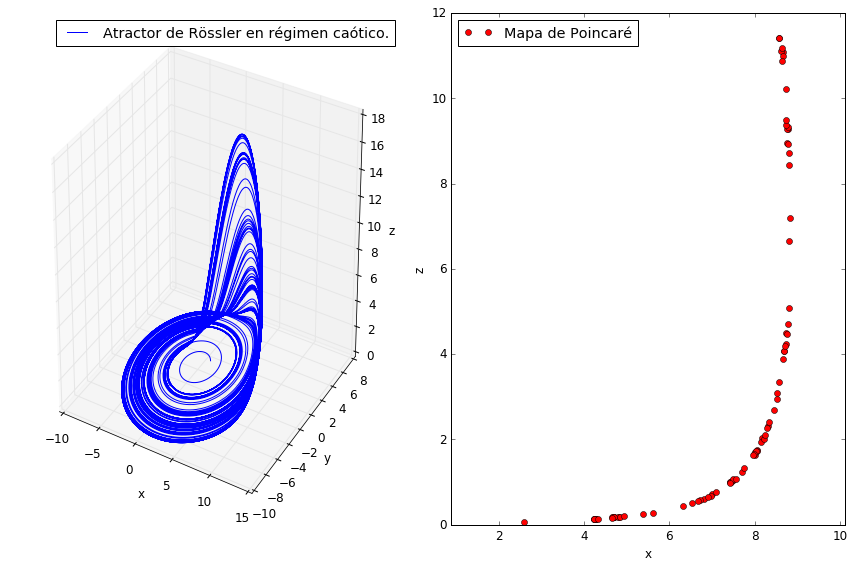

In [6]:
#el archivo rossler_caos.dat está para bajar en el repo, pongan el file_path donde lo tengan guardado
file_path = os.path.join('talleresfifabsas', 'python', 'aplicaciones', 'dinamica', 'mapas')

rossler = os.path.join(file_path, 'rossler_caos.dat')
t_r, x_r, y_r, z_r = np.loadtxt(rossler, delimiter='\t', usecols=(0, 1, 2, 3), unpack=True)

#now we have our temporal series in arrays x_r, y_r and z_r
#plot of the attractor
r_fig = plt.figure(figsize=(12,8))
r_ax = r_fig.add_subplot(121, projection='3d')
attractor = r_ax.plot(x_r, y_r, z_r, 'b-', label=u'Atractor de Rössler en régimen caótico.')
r_ax.set_xlabel('x')
r_ax.set_ylabel('y')
r_ax.set_zlabel('z')
r_ax.legend()

#calculate Poincaré map for the xz plane.
p_mapr = poincare(x_r,y_r,z_r)
p_mapr_ax = r_fig.add_subplot(122)
p_mapr_ax.plot(x_r[p_mapr], z_r[p_mapr], 'ro', label=u'Mapa de Poincaré')
p_mapr_ax.set_xlabel(u'x')
p_mapr_ax.set_ylabel(u'z')
p_mapr_ax.legend(loc='upper left')
p_mapr_ax.set_aspect('equal','datalim')

r_fig.tight_layout()
plt.show(r_fig)

Usamos ahora la función *mutual_info* sobre las series temporales de cada coordenada para determinar un tiempo de retardo óptimo para los embebidos.

/home/jbeiroa/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:293: RuntimeWarning: invalid value encountered in true_divide
  return n/(n*db).sum(), bins


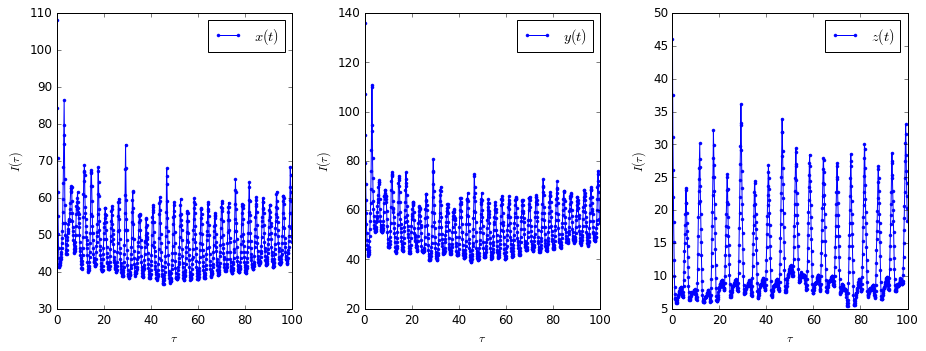

In [9]:
#drop first 25000 values to avoid transient
mi_xr = mutual_info(x_r[25000:])
mi_yr = mutual_info(y_r[25000:])
mi_zr = mutual_info(z_r[25000:])

#make tau vector: one thousand values, to a max of tau=100
tau = np.arange(0, 100, .1) #min, max, step
mr_fig = plt.figure(figsize=(13,5))
mr1_ax = mr_fig.add_subplot(131)
mr1 = mr1_ax.plot(tau ,mi_xr, 'b.-', label=u'$x(t)$')
mr1_ax.set_xlabel(r'$\tau$')
mr1_ax.set_ylabel(r'$I(\tau)$')
mr1_ax.legend()

mr2_ax = mr_fig.add_subplot(132)
mr2 = mr2_ax.plot(tau ,mi_yr, 'b.-', label=u'$y(t)$')
mr2_ax.set_xlabel(r'$\tau$')
mr2_ax.set_ylabel(r'$I(\tau)$')
mr2_ax.legend()

mr3_ax = mr_fig.add_subplot(133)
mr3 = mr3_ax.plot(tau ,mi_zr, 'b.-', label=u'$z(t)$')
mr3_ax.set_xlabel(r'$\tau$')
mr3_ax.set_ylabel(r'$I(\tau)$')
mr3_ax.legend()

mr_fig.tight_layout()
plt.show(mr_fig)

Veamos con más detalle dónde se encuentran los primeros mínimos.

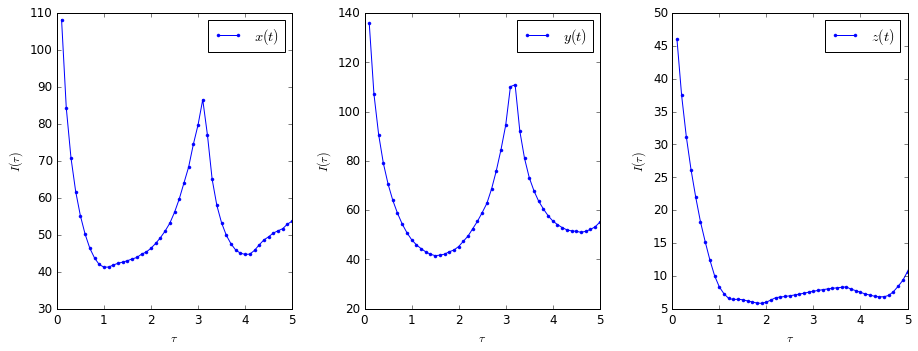

In [10]:
mr1_ax.set_xlim(right=5)
mr2_ax.set_xlim(right=5)
mr3_ax.set_xlim(right=5)
mr_fig

Tomamos entonces, los siguientes tiempos de retardo: para $x(t)$, $\tau=1s$ (~100 muestras); para $y(t)$, $\tau=1.5s$ (~150 muestras); y para $z(t)$, $\tau=2s$ (~200 muestras). Con estos retardos formamos hacemos un embebido para cada serie temporal.

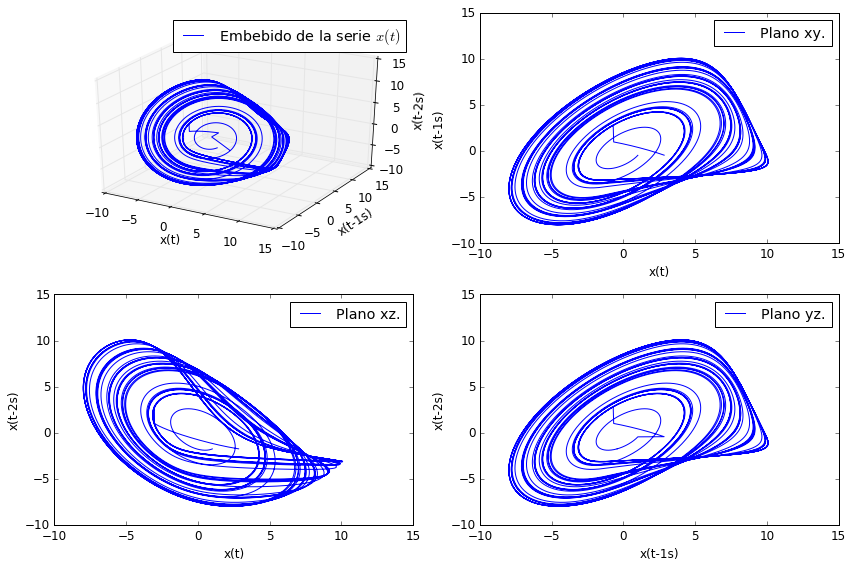

In [11]:
rembx_fig = plt.figure(figsize=(12,8))
ax_rembx1 = rembx_fig.add_subplot(221, projection='3d')
y_rembx = np.roll(x_r[:25000], -100)
z_rembx = np.roll(x_r[:25000], -200)
ax_rembx1.plot(x_r[:25000], y_rembx, z_rembx, label=u'Embebido de la serie $x(t)$')
ax_rembx1.set_xlabel('x(t)')
ax_rembx1.set_ylabel('x(t-1s)')
ax_rembx1.set_zlabel('x(t-2s)')
ax_rembx1.legend()

#projections in xy, xz and yz planes
ax_rembx2 = rembx_fig.add_subplot(222)
ax_rembx2.plot(x_r[:25000], y_rembx, label=u'Plano xy.')
ax_rembx2.set_xlabel('x(t)')
ax_rembx2.set_ylabel('x(t-1s)')
ax_rembx2.legend()

ax_rembx3 = rembx_fig.add_subplot(223)
ax_rembx3.plot(x_r[:25000], z_rembx, label=u'Plano xz.')
ax_rembx3.set_xlabel('x(t)')
ax_rembx3.set_ylabel('x(t-2s)')
ax_rembx3.legend()

ax_rembx4 = rembx_fig.add_subplot(224)
ax_rembx4.plot(y_rembx, z_rembx, label=u'Plano yz.')
ax_rembx4.set_xlabel('x(t-1s)')
ax_rembx4.set_ylabel('x(t-2s)')
ax_rembx4.legend()

rembx_fig.tight_layout()
plt.show(rembx_fig)

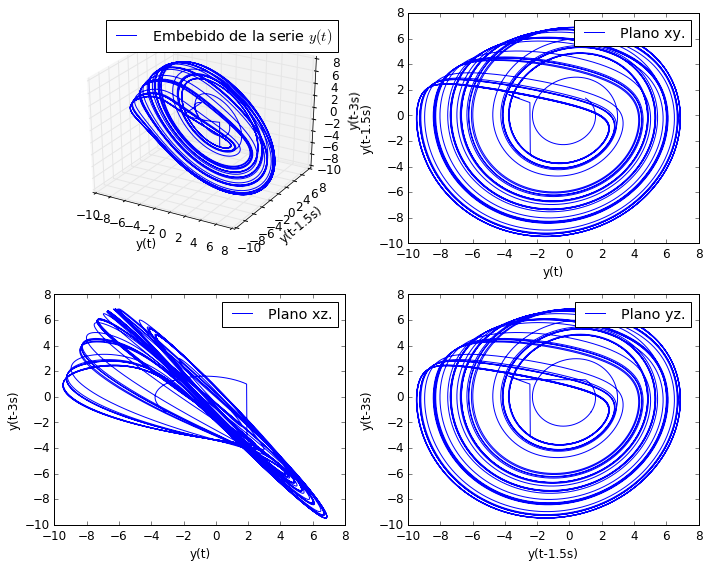

In [12]:
remby_fig = plt.figure(figsize=(10,8))
ax_remby = remby_fig.add_subplot(221, projection='3d')
y_remby = np.roll(y_r[:25000], -150)
z_remby = np.roll(y_r[:25000], -300)
ax_remby.plot(y_r[:25000], y_remby, z_remby, label=u'Embebido de la serie $y(t)$')
ax_remby.set_xlabel('y(t)')
ax_remby.set_ylabel('y(t-1.5s)')
ax_remby.set_zlabel('y(t-3s)')
ax_remby.legend()

#projections in xy, xz and yz planes
ax_remby2 = remby_fig.add_subplot(222)
ax_remby2.plot(y_r[:25000], y_remby, label=u'Plano xy.')
ax_remby2.set_xlabel('y(t)')
ax_remby2.set_ylabel('y(t-1.5s)')
ax_remby2.legend()

ax_remby3 = remby_fig.add_subplot(223)
ax_remby3.plot(y_r[:25000], z_remby, label=u'Plano xz.')
ax_remby3.set_xlabel('y(t)')
ax_remby3.set_ylabel('y(t-3s)')
ax_remby3.legend()

ax_remby4 = remby_fig.add_subplot(224)
ax_remby4.plot(y_remby, z_remby, label=u'Plano yz.')
ax_remby4.set_xlabel('y(t-1.5s)')
ax_remby4.set_ylabel('y(t-3s)')
ax_remby4.legend()

remby_fig.tight_layout()
plt.show(remby_fig)

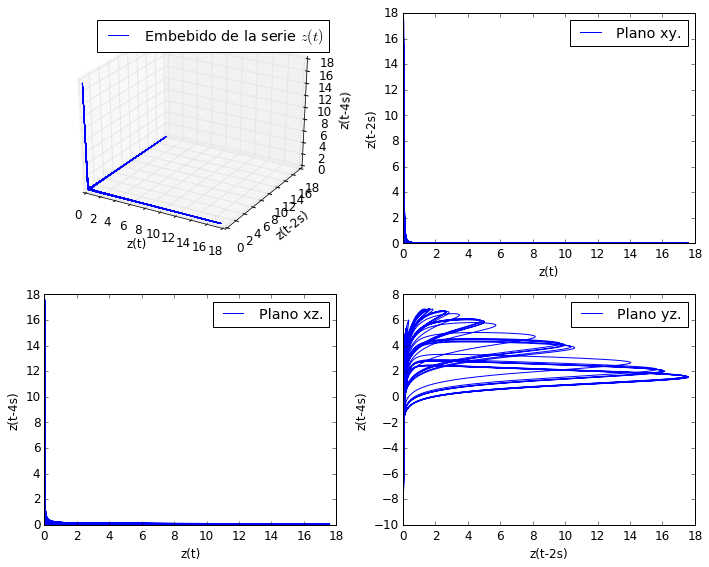

In [13]:
rembz_fig = plt.figure(figsize=(10,8))
ax_rembz = rembz_fig.add_subplot(221, projection='3d')
y_rembz = np.roll(z_r[:25000], -200)
z_rembz = np.roll(z_r[:25000], -400)
ax_rembz.plot(z_r[:25000], y_rembz, z_rembz, label=u'Embebido de la serie $z(t)$')
ax_rembz.set_xlabel('z(t)')
ax_rembz.set_ylabel('z(t-2s)')
ax_rembz.set_zlabel('z(t-4s)')
ax_rembz.legend()

#projections in xy, xz and yz planes
ax_rembz2 = rembz_fig.add_subplot(222)
ax_rembz2.plot(z_r[:25000], y_rembz, label=u'Plano xy.')
ax_rembz2.set_xlabel('z(t)')
ax_rembz2.set_ylabel('z(t-2s)')
ax_rembz2.legend()

ax_rembz3 = rembz_fig.add_subplot(223)
ax_rembz3.plot(z_r[:25000], z_rembz, label=u'Plano xz.')
ax_rembz3.set_xlabel('z(t)')
ax_rembz3.set_ylabel('z(t-4s)')
ax_rembz3.legend()

ax_rembz4 = rembz_fig.add_subplot(224)
ax_rembz4.plot(y_rembz, z_remby, label=u'Plano yz.')
ax_rembz4.set_xlabel('z(t-2s)')
ax_rembz4.set_ylabel('z(t-4s)')
ax_rembz4.legend()

rembz_fig.tight_layout()
plt.show(rembz_fig)

# That's all, folks!